In [1]:
import numpy as np
import pandas as pd

In [2]:
filepath = 'NOTEEVENTS.csv'

In [3]:
pd.read_csv(filepath, nrows=2)

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...


In [4]:
# Look at the first few rows of the CSV file
dtypes = {"ROW_ID": int, "SUBJECT_ID": int, "HADM_ID": float, "CHARTDATE": str, "CHARTTIME": str,
         "STORETIME": str, "CATEGORY": str, "DESCRIPTION": str, "CGID": float, "ISERROR": str, "TEXT": str}
parse_dates = ["CHARTTIME", "STORETIME"]
appended_data = []
chunksize = 10 ** 6
for chunk in pd.read_csv(filepath, dtype = dtypes, parse_dates = parse_dates, chunksize=chunksize):
    appended_data.append(chunk)

In [5]:
appended_data = pd.concat(appended_data)

In [6]:
df = pd.DataFrame(appended_data)
print(df.shape)

(2083180, 11)


In [7]:
df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaT,NaT,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaT,NaT,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaT,NaT,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaT,NaT,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaT,NaT,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [8]:
subject_text_df = df[['SUBJECT_ID','TEXT']]
subject_text_df.head()

,SUBJECT_ID,TEXT
0,22532,Admission Date: [**2151-7-16**] Dischar...
1,13702,Admission Date: [**2118-6-2**] Discharg...
2,13702,Admission Date: [**2119-5-4**] D...
3,13702,Admission Date: [**2124-7-21**] ...
4,26880,Admission Date: [**2162-3-3**] D...


In [9]:
subject_text_df.iloc[0,1]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

In [14]:
sample1 = subject_text_df.sample(frac=0.125, replace=True, random_state=1)

In [15]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

In [16]:
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]
def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [17]:
clean_text(sample1.iloc[0,1])

'ventricular pace probabl atrial fibril previou trace sinu rhythm longer seen'

In [18]:
sample1['TEXT'] = sample1['TEXT'].map(lambda x: clean_text(x))

In [21]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in sample1.iterrows():
    c = Counter(row['TEXT'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

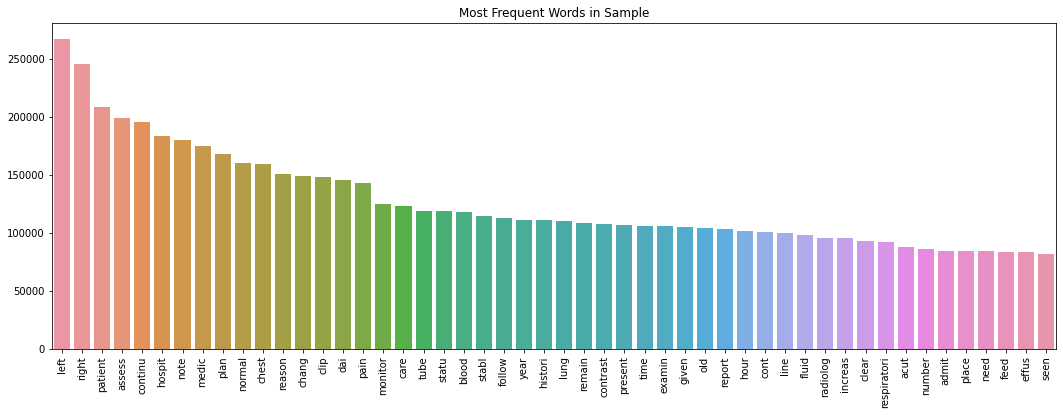

In [23]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words in Sample')

In [27]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row['TEXT']).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row['TEXT']).split())
                                     for index, row in df_x.iterrows()]))

In [28]:
doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr.fit(sample1)
doc2vec_vectors = doc2vec_tr.transform(sample1)

100%|██████████| 260398/260398 [00:00<00:00, 656895.75it/s] 


In [29]:
print(doc2vec_vectors)

[[-1.38495269e-03  1.38079922e-04  4.07852785e-05 ... -9.05495544e-04
   7.48004531e-04  1.23723876e-03]
 [ 3.17508762e-04  1.53670448e-03  3.45987151e-04 ...  8.46250350e-06
   1.36869994e-03  3.16359103e-04]
 [-1.43028318e-03 -9.52670933e-04  1.65774347e-03 ...  1.52392802e-03
  -5.20772650e-04 -1.31839712e-03]
 ...
 [-7.22718367e-04 -1.50061701e-03  6.87105407e-04 ... -1.29372533e-03
   6.86511106e-04  1.16420910e-03]
 [-1.30407978e-03 -1.51492865e-03  4.78656904e-04 ... -8.09065008e-04
  -1.53571006e-03  1.06077164e-03]
 [ 1.13355934e-04 -7.36488088e-04  8.89451127e-04 ...  1.61438750e-03
  -1.21423829e-04  3.90722329e-04]]


In [30]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(
                                                 600,
                                                 150, 
                                                 600,
                                               ))
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

In [31]:
print(predicted_vectors)

[[ 3.06565917e-04  3.76608365e-04  3.19201629e-04 ...  1.77765498e-04
   3.53670561e-04 -1.05650149e-04]
 [ 3.10700785e-04  3.63981924e-04  3.22245108e-04 ...  1.85843384e-04
   3.44194870e-04 -1.08846241e-04]
 [ 3.63743623e-04  2.86626575e-04  3.03284379e-04 ...  2.90677373e-04
   3.28649897e-04 -1.12215760e-04]
 ...
 [ 3.12005558e-04  3.60638230e-04  3.11153431e-04 ...  1.76548808e-04
   3.58275042e-04 -9.27575578e-05]
 [ 3.51805512e-04  3.00032871e-04  2.91113435e-04 ...  2.67292830e-04
   3.61493004e-04 -7.78894107e-05]
 [ 2.99249913e-04  3.75120599e-04  3.21972862e-04 ...  1.46773106e-04
   3.40739653e-04 -1.18027020e-04]]


In [32]:
auto_encoder.score(predicted_vectors, doc2vec_vectors)

0.6016160450695568

In [35]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(sample1)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Subject: ', sample1.iloc[index, 0])  
        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [36]:
print('Top 5 unique notes')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Top 5 unique notes
Subject:  84838
Cosine Sim Val : -0.24334398341362418
---------------------------------
Subject:  10971
Cosine Sim Val : -0.23986720277813567
---------------------------------
Subject:  56861
Cosine Sim Val : -0.2376283569936415
---------------------------------
Subject:  31021
Cosine Sim Val : -0.23017497400188325
---------------------------------
Subject:  61452
Cosine Sim Val : -0.22520821724738238
---------------------------------
